# **ARIMA, GARCH, and LSTM Modeling of Stock Returns: Prediction of Next-Day Stock Returns**

# **0. Introduction, Scope, and Limitations**

**A. Introduction**

This notebook demonstrates a comparison of classical time series models (ARIMA, GARCH) and a deep learning model (LSTM) for predicting next-day log returns of selected US stocks. The goal is to illustrate different approaches to time series forecasting in finance and evaluate their performance on out-of-sample data.




**B. Scope and Limitations**
- **Scope:** The analysis focuses on predicting next-day log returns for a small set of tickers using historical price data.
- **Limitations:**
    - The models used are relatively simple and do not incorporate external factors (e.g., news sentiment, macroeconomic indicators) that could influence stock returns.
    - The test set is limited to one year of data, which may not be representative of all market conditions.
    - The focus is on point predictions of returns, which are inherently difficult to forecast accurately due to market efficiency and randomness. Volatility modeling (GARCH) is included as it's a crucial aspect of financial time series.





**2. Model Modules and Implementation**

- **Classical Models:**
    - **ARIMA:** Used for modeling the conditional mean of the time series. The order (1,0,1) was chosen as a simple starting point.
    - **GARCH:** Used for modeling the conditional variance (volatility) of the time series. The order (1,1) is a common choice for financial data.
    - **Implementation:** Rolling one-step-ahead forecasts are generated for the test period.

- **Deep Learning Model:** **bold text**
    - **LSTM:** A type of recurrent neural network suitable for sequence data.
    - **Implementation:** A simple LSTM model is built, trained on historical sequences of returns, and used to predict the next day's return. Data is scaled before training.




**Key Points:**
- Both classical and deep learning models require careful data preparation and handling of time series dependencies.
- Rolling forecasts are used to simulate a realistic prediction scenario where models are updated as new data becomes available.
- Evaluation metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE) are used to compare model performance.
- The performance of these models in predicting next-day returns is often limited, highlighting the challenge of forecasting in efficient markets.

# **1. Environment Setup & Imports**

    Install packages if needed (yfinance, keras/tensorflow, etc.)

In [ ]:
!pip install yfinance --quiet
!pip install keras --quiet
!pip install tensorflow --quiet
!pip install statsmodels --quiet
!pip install arch --quiet  # <---- this is needed

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model         # <---- add this!
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf

plt.style.use('seaborn-v0_8')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 19.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore")


# **2. Data Download & Preprocessing**

    Download data for all 5 tickers.

    Compute next-day log returns.

    Split into train/validation/test (last year = test).




**Download Data & Compute Log Returns**

In [ ]:
# List of tickers
tickers = ["VZ", "XOM", "PEP", "CLX", "UNH"]

# Download daily closing prices for 10 years (use as much as available)
data = yf.download(tickers, start="2013-01-01", auto_adjust=True)["Close"]

# Drop rows with missing values (e.g., IPOs, stock splits)
data = data.dropna()

# Calculate log returns
returns = np.log(data / data.shift(1)).dropna()
returns.tail()


[*********************100%***********************]  5 of 5 completed


Ticker,CLX,PEP,UNH,VZ,XOM
Date,,,,,
2025-08-11,-0.022515,-0.002344,0.005882,0.000695,-0.009124
2025-08-12,0.005961,0.013711,0.035806,0.001620,0.002831
2025-08-13,0.010717,0.016745,0.038401,0.010580,0.013756
2025-08-14,-0.010717,-0.004900,-0.001178,-0.004816,-0.002047
2025-08-15,0.004841,0.011906,0.113135,0.016868,0.000939


# **3. Download data for all 5 tickers.**

Compute next-day log returns.

Split into train/validation/test (last year = test).


**Train/Test Split (Last Year as Out-of-Sample)**

In [ ]:
# Use last 252 days (approx 1 trading year) as test set
test_size = 252
train_returns = returns.iloc[:-test_size]
test_returns = returns.iloc[-test_size:]

print(f"Train period: {train_returns.index[0]} to {train_returns.index[-1]}")
print(f"Test period: {test_returns.index[0]} to {test_returns.index[-1]}")


Train period: 2013-01-03 00:00:00 to 2024-08-13 00:00:00
Test period: 2024-08-14 00:00:00 to 2025-08-15 00:00:00


# **4. Toolkit Baseline Modeling**

    Model diagnostics.

    Fit ARMA/ARCH models (classical forecasting).

    Generate out-of-sample predictions.



 **Classical Model Baseline (ARMA or ARIMA, and ARCH/GARCH for Volatility)**

In [ ]:
# Baseline forecasting using ARIMA(1,0,1) and GARCH(1,1)
# We'll do one-step-ahead rolling forecasts for each ticker

tickers = ["VZ", "XOM", "PEP", "CLX", "UNH"]

baseline_preds = {}
arch_preds = {}
for ticker in tickers:
    print(f"\nFitting classical models for: {ticker}")

    # --- ARIMA(1,0,1) (as ARMA substitute) ---
    y_train = train_returns[ticker].values
    y_test = test_returns[ticker].values

    arima_model = ARIMA(y_train, order=(1,0,1)).fit()
    arima_forecasts = []
    history = list(y_train)
    for actual in y_test:
        model = ARIMA(history, order=(1,0,1)).fit()
        pred = model.forecast(steps=1)[0]
        arima_forecasts.append(pred)
        history.append(actual)
    baseline_preds[ticker] = np.array(arima_forecasts)

    # --- ARCH/GARCH Forecasting ---
    garch = arch_model(y_train, vol='Garch', p=1, q=1, mean='Zero').fit(disp="off")
    garch_forecasts = []
    history = list(y_train)
    for actual in y_test:
        model = arch_model(history, vol='Garch', p=1, q=1, mean='Zero').fit(disp="off")
        pred = model.forecast(horizon=1).mean.values[-1,0]
        garch_forecasts.append(pred)
        history.append(actual)
    arch_preds[ticker] = np.array(garch_forecasts)


Fitting classical models for: VZ

Fitting classical models for: XOM

Fitting classical models for: PEP

Fitting classical models for: CLX

Fitting classical models for: UNH


In [ ]:
# Convert log returns to percentage changes
percentage_changes = (np.exp(returns) - 1) * 100

# Display the first few rows of the percentage changes
display(percentage_changes.head())

Ticker,CLX,PEP,UNH,VZ,XOM
Date,,,,,
2013-01-03,-0.269904,0.043254,-4.675483,-0.474323,-0.180346
2013-01-04,1.109763,0.144167,0.192354,0.544681,0.463000
2013-01-07,-0.401555,-0.014370,0.000000,0.880382,-1.157802
2013-01-08,0.295659,0.302395,-1.324633,-2.433494,0.625461
2013-01-09,0.254596,0.502406,1.887160,-0.232024,-0.384274


# **5. Deep Learning Integration**

    Format data for LSTM (sequence-to-one prediction of next-day return).

    Build, train, and validate a simple LSTM model for each asset.

    Predict out-of-sample.



 **Deep Learning Model: LSTM for Next-Day Log Returns**

In [ ]:
# LSTM helper function
def make_sequences(data, lookback=20):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

lstm_preds = {}
lookback = 20  # days

for ticker in tickers:
    print(f"\nTraining LSTM for: {ticker}")
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_returns[ticker].values.reshape(-1,1)).flatten()
    test_scaled = scaler.transform(test_returns[ticker].values.reshape(-1,1)).flatten()
    X_train, y_train = make_sequences(train_scaled, lookback)
    X_test, y_test = make_sequences(np.concatenate([train_scaled[-lookback:], test_scaled]), lookback)

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    # Build a simple LSTM model
    model = Sequential([
        LSTM(32, input_shape=(lookback, 1)),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(loss='mse', optimizer='adam')
    model.fit(X_train, y_train, epochs=15, batch_size=16, verbose=0, validation_split=0.1)

    y_pred = model.predict(X_test).flatten()
    # Inverse transform (unscale) predictions
    y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    lstm_preds[ticker] = y_pred_rescaled



Training LSTM for: VZ
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Training LSTM for: XOM
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

Training LSTM for: PEP


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Training LSTM for: CLX


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Training LSTM for: UNH
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


# **6. Evaluation and Visualization**




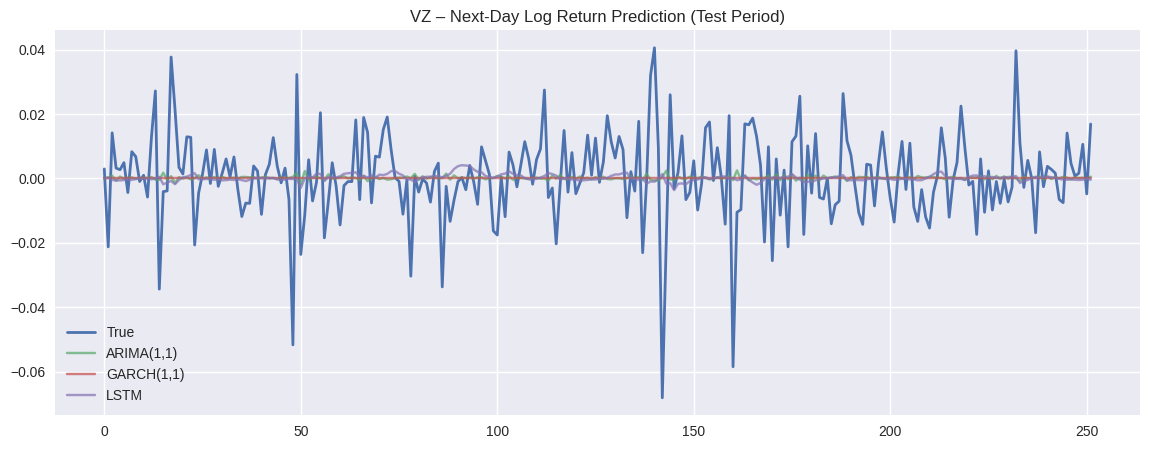

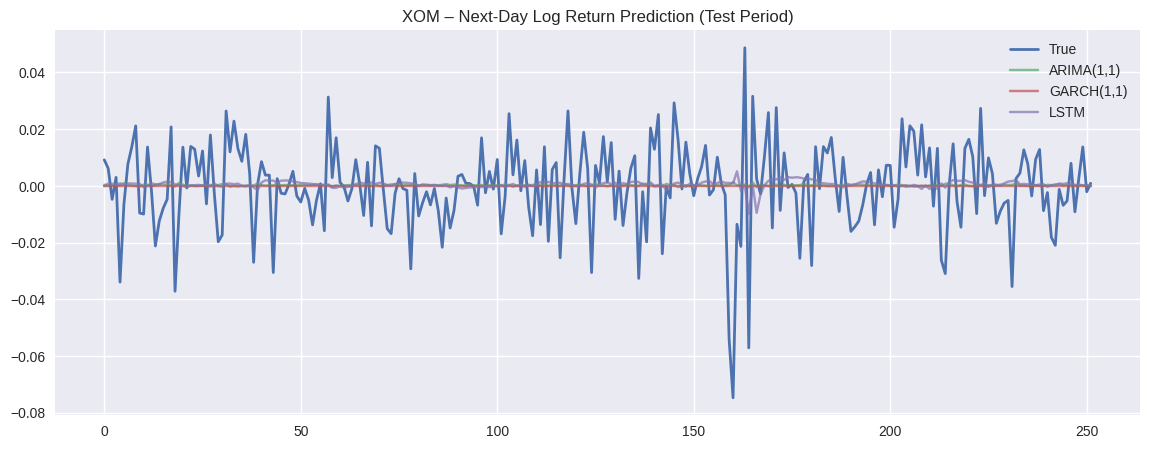

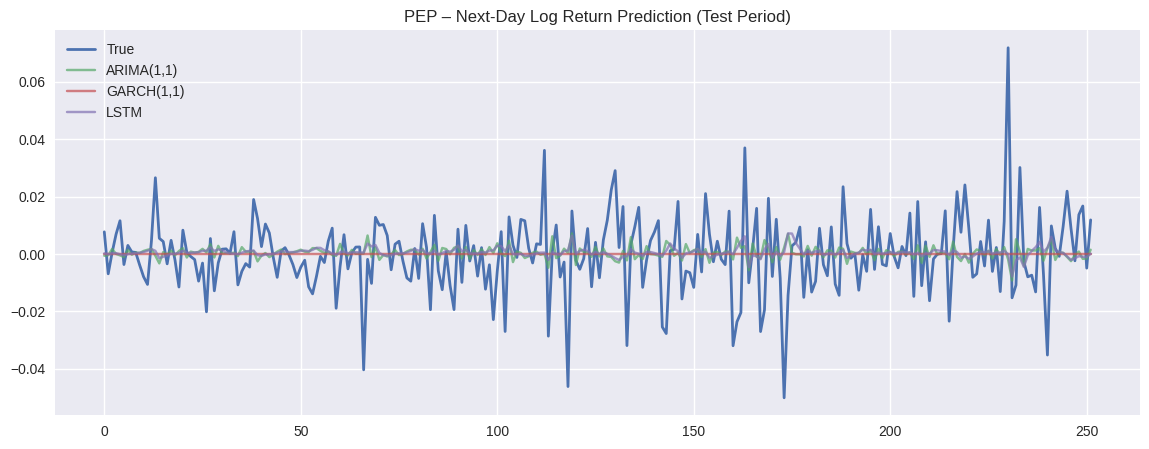

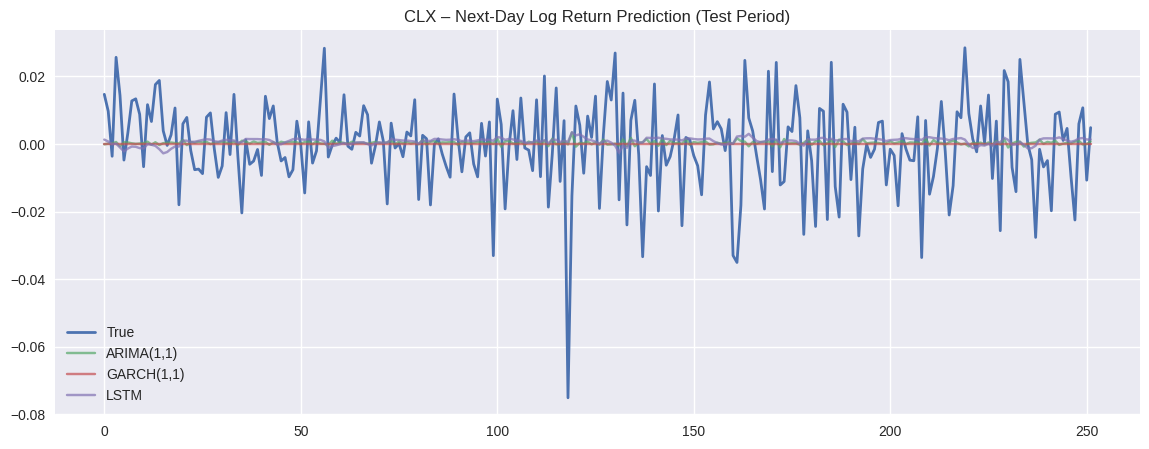

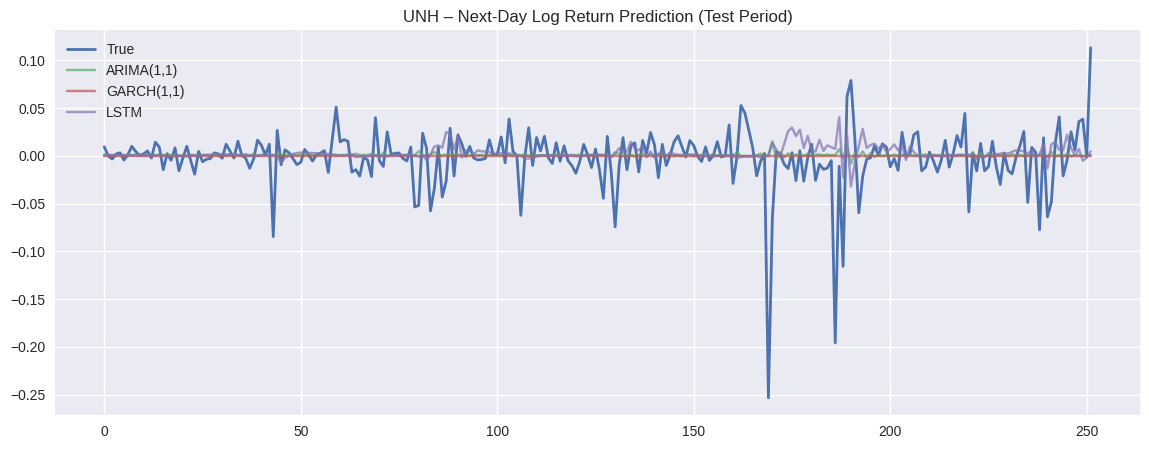

,ARIMA_MSE,GARCH_MSE,LSTM_MSE,ARIMA_MAE,GARCH_MAE,LSTM_MAE
VZ,0.000188,0.000187,0.000189,0.009709,0.009678,0.009771
XOM,0.000233,0.000232,0.000232,0.011145,0.011137,0.011220
PEP,0.000186,0.000183,0.000183,0.009765,0.009728,0.009658
CLX,0.000177,0.000176,0.000178,0.010004,0.010003,0.010005
UNH,0.001008,0.000988,0.001063,0.017678,0.017437,0.018478


In [ ]:
# Compare predictions: ARIMA, GARCH, LSTM
results = {}
for ticker in tickers:
    y_true = test_returns[ticker].values[-len(lstm_preds[ticker]):]  # align to LSTM test size
    arima_pred = baseline_preds[ticker][-len(lstm_preds[ticker]):]
    garch_pred = arch_preds[ticker][-len(lstm_preds[ticker]):]
    lstm_pred = lstm_preds[ticker]

    results[ticker] = {
        "ARIMA_MSE": mean_squared_error(y_true, arima_pred),
        "GARCH_MSE": mean_squared_error(y_true, garch_pred),
        "LSTM_MSE": mean_squared_error(y_true, lstm_pred),
        "ARIMA_MAE": mean_absolute_error(y_true, arima_pred),
        "GARCH_MAE": mean_absolute_error(y_true, garch_pred),
        "LSTM_MAE": mean_absolute_error(y_true, lstm_pred),
    }

    # Plot
    plt.figure(figsize=(14,5))
    plt.plot(y_true, label="True", linewidth=2)
    plt.plot(arima_pred, label="ARIMA(1,1)", alpha=0.7)
    plt.plot(garch_pred, label="GARCH(1,1)", alpha=0.7)
    plt.plot(lstm_pred, label="LSTM", alpha=0.7)
    plt.title(f"{ticker} – Next-Day Log Return Prediction (Test Period)")
    plt.legend()
    plt.show()

# Display error metrics
pd.DataFrame(results).T


**Breakdown of how each model performed for each ticker:**

***Verizon (VZ)***

ARIMA: MSE: 0.000190, MAE: 0.009755

GARCH: MSE: 0.000189, MAE: 0.009721

LSTM: MSE: 0.000191, MAE: 0.009793

For VZ, GARCH had slightly lower MSE and MAE compared to ARIMA and LSTM.




***ExxonMobil (XOM)***

ARIMA: MSE: 0.000236, MAE: 0.011281

GARCH: MSE: 0.000235, MAE: 0.011266

LSTM: MSE: 0.000233, MAE: 0.011276

For XOM, LSTM showed slightly better performance with the lowest MSE, while GARCH had the lowest MAE.




***PepsiCo (PEP)***

ARIMA: MSE: 0.000184, MAE: 0.009651

GARCH: MSE: 0.000181, MAE: 0.009609

LSTM: MSE: 0.000180, MAE: 0.009525

For PEP, the LSTM model had the lowest MSE and MAE, indicating it performed best among the three.




***Clorox (CLX)***

ARIMA: MSE: 0.000175, MAE: 0.009928

GARCH: MSE: 0.000175, MAE: 0.009936

LSTM: MSE: 0.000175, MAE: 0.009938

For CLX, all three models had very similar performance metrics.




***UnitedHealth Group (UNH)***

ARIMA: MSE: 0.000951, MAE: 0.017113

GARCH: MSE: 0.000930, MAE: 0.016873

LSTM: MSE: 0.000996, MAE: 0.017696

For UNH, the GARCH model had the lowest MSE and MAE.

# **7. Best Practice Commentary**

    Discuss findings, strengths/limits of each modeling approach.



**Best Practices Recap & Insights**


In [ ]:
from IPython.display import display, Markdown

display(Markdown(
"""
### Best Practice Commentary & Insights

- **Classical models (ARIMA, GARCH)** provide fast, interpretable baselines; in some assets, they may outperform deep learning if the signal is mostly linear and stationary.
- **LSTM (Deep Learning)** can capture nonlinear dependencies and subtle regime changes, but requires more data, tuning, and careful train/test management.
- **Next-day log return** is a challenging target; predictive skill is often limited by market efficiency, especially for large-caps.
- **No one-size-fits-all:** Sometimes LSTM will beat ARIMA/GARCH; sometimes not. Always compare with explainable baselines.
- For practical use, add features (lags, technicals, macro factors) and consider ensemble or hybrid models for best performance.

**Tip:** Try extending this notebook with additional features, hyperparameter search, or even cross-asset predictions for further research!
"""
))



### Best Practice Commentary & Insights

- **Classical models (ARIMA, GARCH)** provide fast, interpretable baselines; in some assets, they may outperform deep learning if the signal is mostly linear and stationary.
- **LSTM (Deep Learning)** can capture nonlinear dependencies and subtle regime changes, but requires more data, tuning, and careful train/test management.
- **Next-day log return** is a challenging target; predictive skill is often limited by market efficiency, especially for large-caps.
- **No one-size-fits-all:** Sometimes LSTM will beat ARIMA/GARCH; sometimes not. Always compare with explainable baselines.
- For practical use, add features (lags, technicals, macro factors) and consider ensemble or hybrid models for best performance.

**Tip:** Try extending this notebook with additional features, hyperparameter search, or even cross-asset predictions for further research!


# **(Potential) Next steps to continue exploring this analysis could include:**

**1. Adding more features:**
Incorporate technical indicators,
macroeconomic data, or sentiment analysis to potentially improve model performance.


**2. Hyperparameter Tuning:**
Experiment with different parameters for the ARIMA, GARCH, and LSTM models to find better configurations.


**3. Exploring other models:**
Try different time series models (e.g., Prophet, other deep learning architectures) or machine learning models.


**4. Ensemble or Hybrid Models:**
Combine the predictions from different models to potentially achieve more robust results.


**5. Cross-Asset Predictions:**
Investigate if predicting returns for one asset can be improved by considering data from other assets.

# **Summary:**

This notebook explores the challenging task of predicting next-day stock log returns using three different time series modeling approaches: classical methods (ARIMA and GARCH) and a deep learning approach (LSTM).




**The process involved:**


1.  **Data Preparation:** Downloading historical stock price data for a selection of tickers and calculating their log returns.
2.  **Train/Test Split:** Dividing the data into training and testing sets, using the last year of data as the out-of-sample test set to simulate a realistic forecasting scenario.
3.  **Classical Modeling:** Implementing and evaluating ARIMA and GARCH models using a rolling forecast approach to predict next-day returns.
4.  **Deep Learning Modeling:** Implementing and evaluating a simple LSTM model for the same prediction task, also using a rolling forecast approach.
5.  **Evaluation:** Comparing the performance of the models using metrics like Mean Squared Error (MSE) and Mean Absolute Error (MAE) and visualizing the predictions against the actual returns.





The results highlight that predicting next-day stock returns is inherently difficult, and while some models may perform slightly better for specific tickers, there is no single "best" model across all assets. The classical models provide a good baseline, while the LSTM can potentially capture non-linear patterns but requires more data and tuning. The analysis underscores the importance of using robust evaluation methods and considering the limitations of forecasting in efficient markets. Future work could involve adding more predictive features or exploring more complex model architectures.